# Simple Nonlinear Node

In [1]:
using RxInfer, Random, StableRNGs

Here is an example of creating custom node with nonlinear function approximation with samplelist.

### Custom node creation

In [2]:
struct NonlinearNode end # Dummy structure just to make Julia happy

struct NonlinearMeta{R, F}
    rng      :: R
    fn       :: F   # Nonlinear function, we assume 1 float input - 1 float output
    nsamples :: Int # Number of samples used in approximation
end

In [3]:
@node NonlinearNode Deterministic [ out, in ]

We need to define two Sum-product message computation rules for our new custom node
- Rule for outbound message on `out` edge given inbound message on `in` edge
- Rule for outbound message on `in` edge given inbound message on `out` edge
- Both rules accept optional meta object

In [4]:
# Rule for outbound message on `out` edge given inbound message on `in` edge
@rule NonlinearNode(:out, Marginalisation) (m_in::NormalMeanVariance, meta::NonlinearMeta) = begin 
    samples = rand(meta.rng, m_in, meta.nsamples)
    return SampleList(map(meta.fn, samples))
end

In [5]:
# Rule for outbound message on `in` edge given inbound message on `out` edge
@rule NonlinearNode(:in, Marginalisation) (m_out::Gamma, meta::NonlinearMeta) = begin     
    return ContinuousUnivariateLogPdf((x) -> logpdf(m_out, meta.fn(x)))
end

### Model specification

After we have defined our custom node with custom rules we may proceed with a model specification:

$$\begin{aligned}
p(\theta) &= \mathcal{N}(\theta|\mu_{\theta}, \sigma_{\theta}),\\
p(m) &= \mathcal{N}(\theta|\mu_{m}, \sigma_{m}),\\
p(w) &= f(\theta),\\
p(y_i|m, w) &= \mathcal{N}(y_i|m, w),
\end{aligned}$$

Given this IID model, we aim to estimate the precision of a Gaussian distribution. We pass a random variable $\theta$ through a non-linear transformation $f$ to make it positive and suitable for a precision parameter of a Gaussian distribution. We, later on, will estimate the posterior of $\theta$. 

In [6]:
@model function nonlinear_estimation(y, θ_μ, m_μ, θ_σ, m_σ)
    
    # define a distribution for the two variables
    θ ~ Normal(mean = θ_μ, variance = θ_σ)
    m ~ Normal(mean = m_μ, variance = m_σ)

    # define a nonlinear node
    w ~ NonlinearNode(θ)

    # We consider the outcome to be normally distributed
    for i in eachindex(y)
        y[i] ~ Normal(mean = m, precision = w)
    end
    
end

In [7]:
@constraints function nconstsraints(nsamples)
    q(θ) :: SampleListFormConstraint(nsamples, LeftProposal())
    q(w) :: SampleListFormConstraint(nsamples, RightProposal())
    
    q(θ, w, m) = q(θ)q(m)q(w)
end

nconstsraints (generic function with 1 method)

In [8]:
@meta function nmeta(fn, nsamples)
    NonlinearNode(θ, w) -> NonlinearMeta(StableRNG(123), fn, nsamples)
end

nmeta (generic function with 1 method)

In [9]:
@initialization function ninit()
    q(m) = vague(NormalMeanPrecision)
    q(w) = vague(Gamma)
end

ninit (generic function with 1 method)

Here we generate some data

In [10]:
nonlinear_fn(x) = abs(exp(x) * sin(x))

nonlinear_fn (generic function with 1 method)

In [11]:
seed = 123
rng  = StableRNG(seed)

niters   = 15 # Number of VMP iterations
nsamples = 5_000 # Number of samples in approximation

n = 500 # Number of IID samples
μ = -10.0
θ = -1.0
w = nonlinear_fn(θ)

data = rand(rng, NormalMeanPrecision(μ, w), n);

now that synthetic data/constriants/model is defined, lets infer:

In [12]:
result = infer(
    model = nonlinear_estimation(θ_μ = 0.0, m_μ = 0.0, θ_σ=100.0, m_σ=1.0),
    meta =  nmeta(nonlinear_fn, nsamples),
    constraints = nconstsraints(nsamples),
    data = (y = data, ), 
    initialization = ninit(),
    returnvars = (θ = KeepLast(), ),
    iterations = niters,  
    showprogress = true
)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


Inference results:
  Posteriors       | available for (θ)


we can check the posterior now

In [13]:
θposterior = result.posteriors[:θ]

SampleList(Univariate, 5000)

Let's us visualise the results

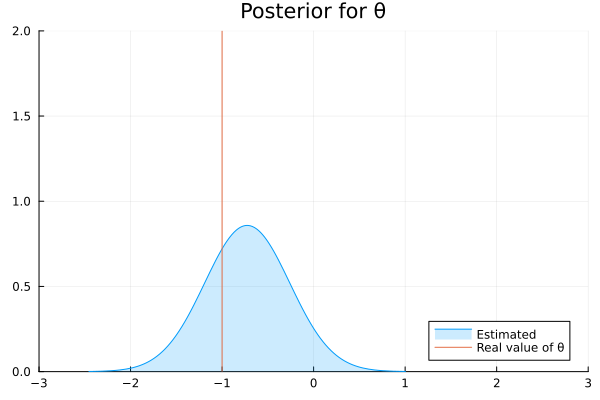

In [14]:
using Plots, StatsPlots

estimated = Normal(mean_std(θposterior)...)

plot(estimated, title="Posterior for θ", label = "Estimated", legend = :bottomright, fill = true, fillopacity = 0.2, xlim = (-3, 3), ylim = (0, 2))
vline!([ θ ], label = "Real value of θ")